<a href="https://colab.research.google.com/github/rifahzahid/RifahMSAI2k21/blob/main/CV_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
 
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def otherAccuracyMeasures(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)   

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print("True Positive Rate OR Recall:", TPR)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print("True Negative Rate:", TNR)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Positive Predictive Value OR Precision:", PPV)
    # Negative predictive value
    NPV = TN/(TN+FN)
    print("Negative Predictive Value:", NPV)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print("False Positive Rate:", FPR)
    # False negative rate
    FNR = FN/(TP+FN)
    print("False Negative Rate:", FNR)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("False Discovery Rate:", FDR)
    #F1 Score
    F1 = (PPV*TPR)/PPV+TPR
    print("F1 Score:", F1)

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["00001", "00002", "00003", "00004", "00005", "00006", "00007", "00008", "00009", "00010"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

def IncorrectlyClassifiedExamples(true, predictions):
    misclassified_samples = true != predictions
    for i in range(5):
       np.flatnonzero(true != predictions)

def CorrectlyClassifiedExamples(true, predictions):
    misclassified_samples = true == predictions
    for i in range(5):
       np.flatnonzero(true != predictions)

In [43]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 10
    image_count = len(images)

    for img_path in images:
        if("00001" in img_path):
            class_index = 0
        elif("00002" in img_path):
            class_index = 1
        elif("00003" in img_path):
            class_index = 2
        elif("00004" in img_path):
            class_index = 3
        elif("00005" in img_path):
            class_index = 4  
        elif("00006" in img_path):
            class_index = 5
        elif("00007" in img_path):
            class_index = 6
        elif("00008" in img_path):
            class_index = 7
        elif("00009" in img_path):
            class_index = 8
        elif("00010" in img_path):
            class_index = 9       
        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


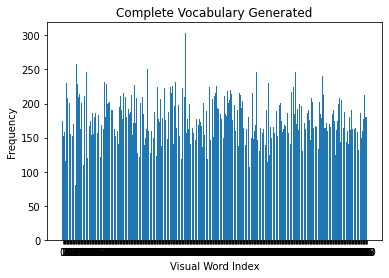

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
--- 515.5285260677338 seconds ---


In [86]:
train_path = "drive/MyDrive/train"
test_path  = "drive/MyDrive/test"
no_clusters = 500
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

In [6]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.7 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 30.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [76]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "00001",
        "1": "00002",
        "2": "00003",
        "3": "00004",
        "4": "00005",
        "5": "00006",
        "6": "00007",
        "7": "00008",
        "8": "00009",
        "9": "00010",
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("00001" in img_path):
                true.append("00001")
            elif("00002" in img_path):
                true.append("00002")
            elif("00003" in img_path):
                true.append("00003")
            elif("00004" in img_path):
                true.append("00004")
            elif("00005" in img_path):
                true.append("00005")
            elif("00006" in img_path):
                true.append("00006")
            elif("00007" in img_path):
                true.append("00007")
            elif("00008" in img_path):
                true.append("00008")
            elif("00009" in img_path):
                true.append("00009")
            else:
                true.append("00010")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    otherAccuracyMeasures(true, predictions)
    print("Other measures calculated")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

    IncorrectlyClassifiedExamples(true, predictions)
    CorrectlyClassifiedExamples(true, predictions)

Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[47 29  0  3  0  1  0  2  0  2]
 [23 19  2  1  2  0  3  3  1  2]
 [ 2  3  4  0  0  0  0  0  0  0]
 [ 3  1  0  3  0  0  0  1  0  0]
 [ 4  3  0  0  0  0  0  0  0  0]
 [ 6  1  0  0  0  1  0  0  0  0]
 [ 4  0  0  0  0  0  3  0  0  0]
 [ 4  1  0  0  0  0  0  1  0  0]
 [ 4  3  0  0  0  0  0  0  0  0]
 [ 3  1  0  0  0  0  1  0  0  3]]
Normalized confusion matrix
[[0.56 0.35 0.   0.04 0.   0.01 0.   0.02 0.   0.02]
 [0.41 0.34 0.04 0.02 0.04 0.   0.05 0.05 0.02 0.04]
 [0.22 0.33 0.44 0.   0.   0.   0.   0.   0.   0.  ]
 [0.38 0.12 0.   0.38 0.   0.   0.   0.12 0.   0.  ]
 [0.57 0.43 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.75 0.12 0.   0.   0.   0.12 0.   0.   0.   0.  ]
 [0.57 0.   0.   0.   0.   0.   0.43 0.   0.   0.  ]
 [0.67 0.17 0.   0.   0.   0.   0.   0.17 0.   0.  ]
 [0.57 0.43 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.38 0.12 0.   0.   0.   0.   0.12 0.   0.   0.38]]


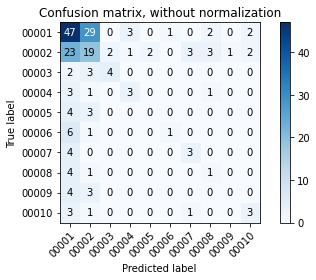

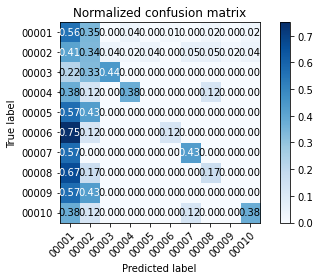

Confusion matrixes plotted.
True Positive Rate OR Recall: [0.56 0.34 0.44 0.38 0.   0.12 0.43 0.17 0.   0.38]
True Negative Rate: [0.54 0.71 0.99 0.98 0.99 0.99 0.98 0.97 0.99 0.98]
Positive Predictive Value OR Precision: [0.47 0.31 0.67 0.43 0.   0.5  0.43 0.14 0.   0.43]
Negative Predictive Value: [0.63 0.73 0.97 0.97 0.96 0.96 0.98 0.97 0.96 0.97]
False Positive Rate: [0.46 0.29 0.01 0.02 0.01 0.01 0.02 0.03 0.01 0.02]
False Negative Rate: [0.44 0.66 0.56 0.62 1.   0.88 0.57 0.83 1.   0.62]
False Discovery Rate: [0.53 0.69 0.33 0.57 1.   0.5  0.57 0.86 1.   0.57]
F1 Score: [1.12 0.68 0.89 0.75  nan 0.25 0.86 0.33  nan 0.75]
Other measures calculated
accuracy score: 0.405
Accuracy calculated.
Execution done.
--- 12.109635353088379 seconds ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


In [87]:
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))